<h2>Imports</h2>
<ul>
    <li>Pandas</li>
    <li>Numpy</li>
    <li>Matplotlib</li>
    <li>Seaborn</li>
    <li>Scikit-Learn</li>
</ul>

In [10]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import copy

# Scikit_Learn imports
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler

<h2>Load data</h2>
<ul>
    <li>Load train data</li>
    <li>Load test data</li>
</ul>

In [5]:
X_train = pd.read_csv('./Homework_04/Dataset/train.csv')
X_test = pd.read_csv('./Homework_04/Dataset/test.csv')

<h2>Preprocessing</h2>
<ul>
    <li>Normalize</li>
    <li>Handle missing values (already done)</li>
    <li>Handle categorical values (already done)</li>
</ul>

In [9]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

<h2>PCA</h2>
<h5>Apply PCA using repeatedKfolds and then inverse transform the images and finally compute MSE and plot boxplots</h5>

In [16]:
# Define desired dimensions
desired_dimensions = [200, 140, 100, 70, 45, 30, 15, 8, 3]

# Final MSEs
mse_errors = dict()

# Start to fit
for dimension in desired_dimensions:
    # Define Repeated K Folds 
    cv = RepeatedKFold(n_repeats=10, n_splits=5, random_state=42)

    # Shuffle the Training data
    np.random.shuffle(X_train)

    for train_index, validation_index in cv.split(X_train):
        X_train_fold = X_train[train_index]
        X_validation_fold = X_train[validation_index]

        # Apply PCA
        pca = PCA(n_components=dimension)
        X_train_fold_reduced = pca.fit_transform(X_train_fold)  # Fit transform on 80% of the train set
        X_validation_fold_reduced = pca.transform(X_validation_fold)  # Transform validation set 
        X_train_fold_reconstructed = pca.inverse_transform(X_train_fold_reduced)  # Reconstruct the train part again
        X_validation_fold_reconstructed = pca.inverse_transform(X_validation_fold_reduced)  # Reconstruct the validation part again

        # Calculate MSE
        mse_train_fold = MSE(X_train_fold, X_train_fold_reconstructed)
        mse_validation_fold = MSE(X_validation_fold, X_validation_fold_reconstructed)

        # Store MSE of validation and train folds
        if dimension not in mse_errors:
            mse_errors[dimension] = {'train': [copy.deepcopy(mse_train_fold)], 'validation': [copy.deepcopy(mse_validation_fold)]}
        elif dimension in mse_errors:
            mse_errors[dimension]['train'].append(copy.deepcopy(mse_train_fold))
            mse_errors[dimension]['validation'].append(copy.deepcopy(mse_validation_fold))
        else:
            raise Exception("ERROR")

<h2>Boxplot</h2>
<h5>Plot boxplot for validation fold and train fold for each chosen dimension</h5>

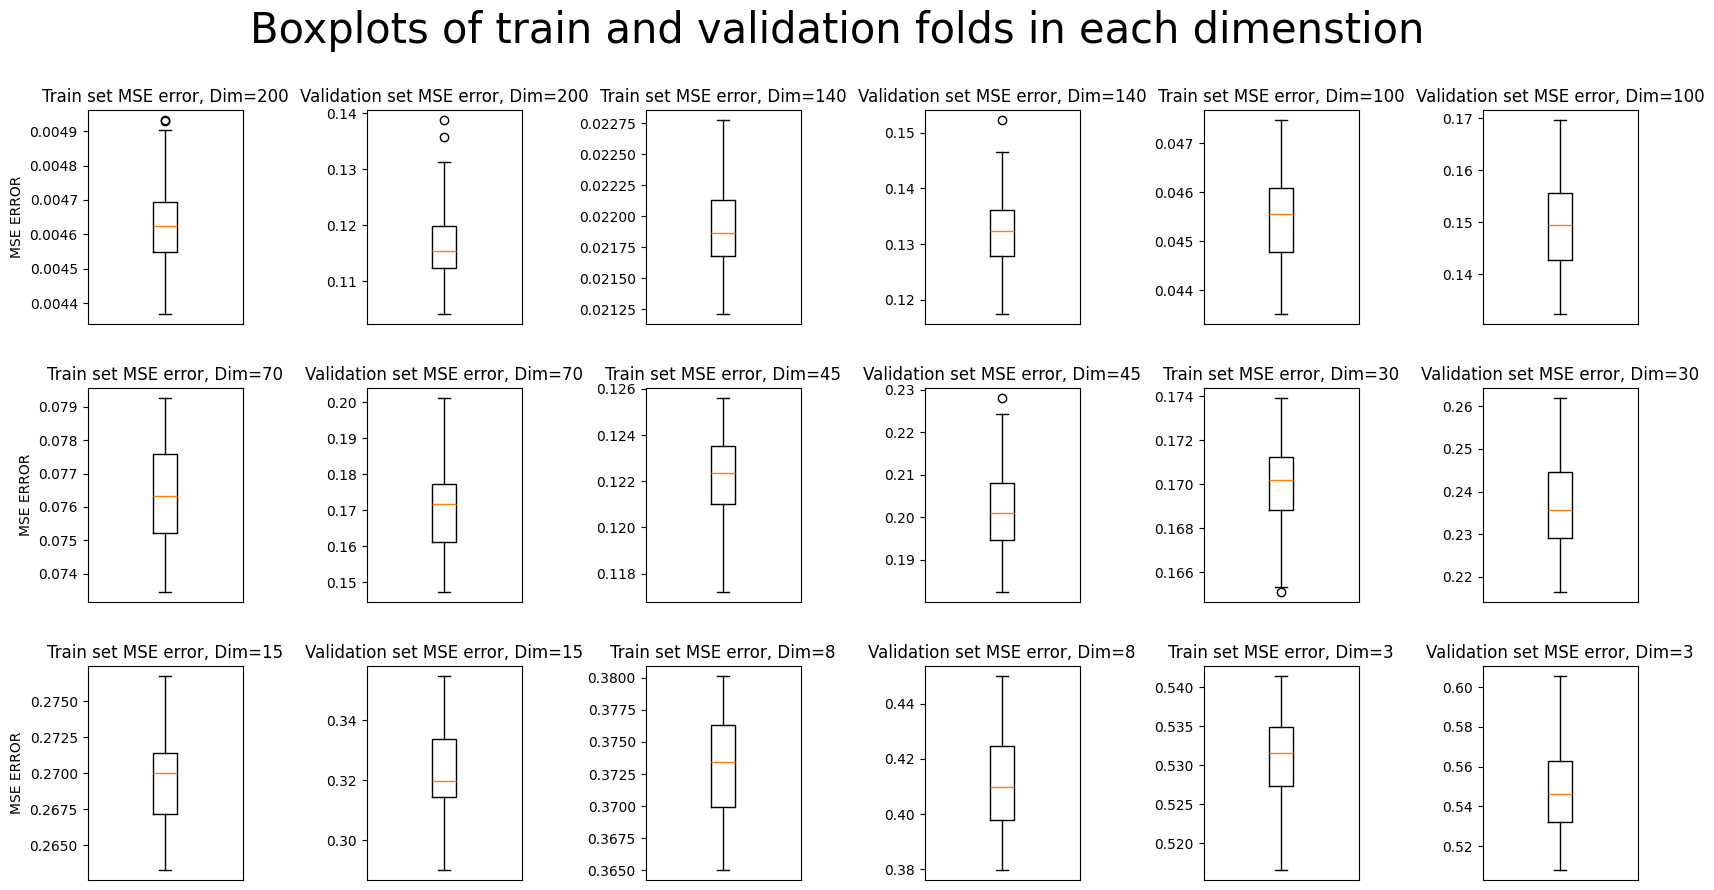

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
fig.suptitle("Boxplots of train and validation folds in each dimenstion", fontsize=30)
fig.subplots_adjust(wspace=0.8, hspace=0.3)

for i in range(0, 18, 2):
    ax_1 = axes[i // 6, i % 6]
    ax_2 = axes[i // 6, (i % 6) + 1]
    ax_1.boxplot(mse_errors[desired_dimensions[i // 2]]['train'])
    ax_2.boxplot(mse_errors[desired_dimensions[i // 2]]['validation'])
    ax_1.xaxis.set_visible(False)
    ax_2.xaxis.set_visible(False)
    ax_1.set_title(f"Train set MSE error, Dim={desired_dimensions[i // 2]}")
    ax_2.set_title(f"Validation set MSE error, Dim={desired_dimensions[i // 2]}")

axes[0, 0].set_ylabel("MSE ERROR")
axes[1, 0].set_ylabel("MSE ERROR")
axes[2, 0].set_ylabel("MSE ERROR")

plt.show()